# Author advantage and swaps (test data)

## Import packages

In [1]:
import pandas as pd
import math

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch

import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore")

from enum import IntEnum

import json


## Set filepaths

In [2]:
ranking = '../evaluation/resources/2020/jsonruns/p_controller_train_nle_meta_9_1_train.json'
eval_result_hlevel = '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_9_1_train_hlevel.tsv'
eval_result_level = '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_9_1_train_level.tsv'
gt = '../pre_processing/resources/training/2020/TREC-Fair-Ranking-training-sample.json'
est_rel_meta_p = '../reranking/resources/relevances/Training_rel_scores_model_A.csv'
annotations = '../pre_pre_processing/resources/merged-annotations.json'
mapping = '../reranking/resources/mappings/training_doc_to_author.json'

## Prepare dataframes

In [190]:
# ranking df
rdf = pd.read_json(ranking, lines=True)

# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]

# eval result dfs
ehldf = pd.read_csv(eval_result_hlevel, sep='\t', names=['key', 'qid', 'value'])
ehldf = ehldf.pivot(index='qid', columns='key', values='value')

eldf = pd.read_csv(eval_result_level, sep='\t', names=['key', 'qid', 'value'])
eldf = eldf.pivot(index='qid', columns='key', values='value')


# est rel df
est_rel_meta = pd.read_csv(est_rel_meta_p)
est_rel_meta.head()

# annotations
adf = pd.read_json(annotations,lines=True)
adf = adf.explode('authors')
adf[['name','wiki','country','type','valid','auth_id', 'h_index','level','region']] = adf.authors.apply(pd.Series).rename({'id':'auth_id'},axis=1)

# doc to author and reverse mapping
with open(mapping) as fp:
    doc_to_author = json.load(fp)
alldocs = rdf.explode('ranking')['ranking'].drop_duplicates().to_list()
for doc in alldocs:
    if not doc in doc_to_author:
        doc_to_author[doc] = []
    
author_to_doc = {}
for doc, aulist in doc_to_author.items():
    for au in aulist:
        if not au in author_to_doc:
            author_to_doc[au] = []
        author_to_doc[au] = author_to_doc[au] + [doc]

In [4]:
doc_to_author['2423ea8cf66765d79363988086bf0f6066a13872']

['1402911985', '82779085', '96547788']

In [5]:
author_to_doc['82779085']

['2423ea8cf66765d79363988086bf0f6066a13872']

In [6]:
rdf.head(2)

,q_num,qid,ranking
0,0.0,5438,"[b2fdee22aa02477292b858fbafcb418932732bce, 993..."
1,0.1,5438,"[70f3a58b0fc6916c2e6616bfbae5758c00408894, ec1..."


In [7]:
gtdf.head(2)

,qid,query,frequency,documents,doc_id,doc_rel
0,5438,cloud computing,0.000057,{'doc_id': '3e19046c665867bbe557685da60738a407...,3e19046c665867bbe557685da60738a40738010a,0
0,5438,cloud computing,0.000057,{'doc_id': '7ef08f1fa127af817cdfd9d3bd00bdf60e...,7ef08f1fa127af817cdfd9d3bd00bdf60e32143b,0


In [8]:
reldf.head(2)

,qid,query,doc_id,doc_rel
0,5438,cloud computing,3e19046c665867bbe557685da60738a40738010a,0
0,5438,cloud computing,7ef08f1fa127af817cdfd9d3bd00bdf60e32143b,0


In [9]:
ehldf.head(2)

key,difference,disparity,relevance
qid,,,
69,0.146308,2.820826,2.254359
258,0.549351,1.043557,0.679082


In [10]:
eldf.head(2)

key,difference,disparity,relevance
qid,,,
69,0.211649,3.322678,2.491326
258,0.479589,2.230424,1.349051


In [11]:
adf.head(2)

,id,missing_authors,authors,name,wiki,country,type,valid,auth_id,h_index,level,region
0,f3b7db81ee8642cf2deab7a9834e07b8df54185b,False,"{'name': 'David M. Szymanski', 'wiki': 'Texas ...",David M. Szymanski,Texas A&M University,US,academic,True,50215565.0,9.0,Advanced,Americas
0,f3b7db81ee8642cf2deab7a9834e07b8df54185b,False,"{'name': 'David H. Henard', 'wiki': 'North Car...",David H. Henard,North Carolina State University,US,academic,True,115002169.0,8.0,Advanced,Americas


We order the queries from lowest to highest DGEE according to each grouping. Then we plot the "difficulty rank" of each query according to the "hlevel" grouping against its difficulty according to the "level" grouping. This allows us to see if the DGEE for both groupings is generally in accordance or not.

In [24]:
edf_m = pd.merge(ehldf.sort_values(by='difference').reset_index().reset_index(),eldf.sort_values(by='difference').reset_index().reset_index(),on='qid')
edf_m = edf_m.rename({'index_x':'difficulty hlevel', 'index_y':'difficulty econ level'},axis=1)
edf_m.head()

key,difficulty hlevel,qid,difference_x,disparity_x,relevance_x,difficulty econ level,difference_y,disparity_y,relevance_y
0,0,132049,0.002713,1.421254,1.403715,0,0.002713,1.421254,1.403715
1,1,71096,0.029287,1.975807,1.862498,1,0.026328,1.972820,1.862484
2,2,21984,0.032334,1.367385,1.271935,6,0.071535,1.515766,1.326630
3,3,15395,0.040510,2.053024,1.890567,2,0.026948,2.035232,1.888323
4,4,52728,0.057478,1.047360,0.839632,13,0.098930,1.011948,0.728643


Text(0.5, 0.98, 'Difficulty for H-index grouping versus econ level grouping')

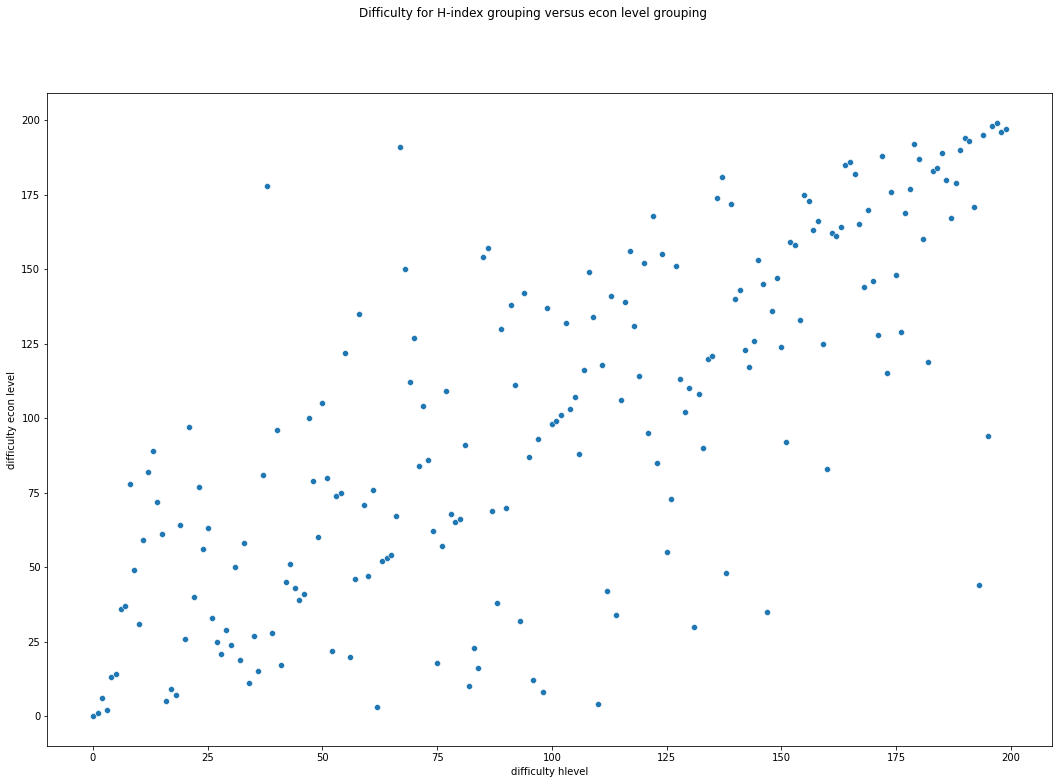

In [25]:
fig, ax = plt.subplots(1,1,figsize=(18,12))

sns.scatterplot(data=edf_m, x='difficulty hlevel', y='difficulty econ level',ax=ax)
fig.suptitle('Difficulty for H-index grouping versus econ level grouping')

We see a clear upward trend in the plot above. This tells us that in general, the DGEE according to the two groupings is similar. We would not expect great differences in the analysis results for different groupings.

In [26]:
edf = edf_m.copy()
edf['difference'] = edf.apply(lambda row: (row.difference_x + row.difference_y)/2, axis=1)
edf['disparity'] = edf.apply(lambda row: (row.disparity_x + row.disparity_y)/2, axis=1)
edf['relevance'] = edf.apply(lambda row: (row.relevance_x + row.relevance_y)/2, axis=1)

edf = edf.sort_values(by='difference')[['qid','difference', 'disparity', 'relevance']]
edf.head()

key,qid,difference,disparity,relevance
0,132049,0.002713,1.421254,1.403715
1,71096,0.027807,1.974314,1.862491
3,15395,0.033729,2.044128,1.889445
2,21984,0.051934,1.441575,1.299282
4,52728,0.078204,1.029654,0.784137
